# *New Evidence of Discrimination Among Local Election Officials*

**THIS IS A ONE DAY FILE FOR 2017 APSA** This paper has not been peer reviewed, and so these code are not final

**Authors**

D. Alex Hughes, University of California, Berkeley
Micah Gell-Redman, University of Georgia
Natarajan Krishnaswami, University of California, Berkeley
Diana Rodenberger, University of California, Berkeley
Guillermo Monge, University of California, Berkeley
Charles Crabtree, University of Michigan


**Analysis Date** 
August, 2017

This file produces the analysis that accompanies the paper "Who else gets to Vote?". The analysis in this file contains more than is directly reported in the presented file. As such, it is possible that some of this analysis did not undergo peer review, and should be considered as such. 

<a id="toc"></a>
**Table of Contents** 
1. [Exploratory Data Analysis](#eda)
  1. [Randomization](#randomization) 
  2. [Response Rate by Experimental Condition](#rbc)
  3. [Differences in Baseline Responses, by Geography (Non-Experimental)](#stateDiffs) 
  4. [Most and Least Responsive States (Non-Experimental)](#mostLeast)

2. [Experimental Results](#experimentalResults)
  1. [Differences in Response Rates by Ethnic Condition(s)](#experimentalResults) 
  2. [Estimating Treatment Effects using OLS Models](#ols)
  3. [Improving Model Performance Using Blocks](#blocks) 
  4. [Improving Model Performance Using Blocks and Covariates](#covariates)
  5. [Precision Weighted Treatment Effect Estimates](#precisionWeighted)
  6. [Plot of Precision Weighted Estimates](#precisionWeightedPlot)

3. [Heterogenenous Treatment Effects](#hte)
  1. [Racial and Ethnic District Characteristics](#demos)
  2. [Political Characteristics](#politics)

4. [Interruption by Notification](#interruption)
  1. [Rates of Response as function of Time Since Sending](#rateOfResponse)
  2. [Time taken for Response](#timeToRespond)
  3. [No Difference in Estimated Effect From Email](#noInterruptionDifference)

In [1]:
require(data.table, quietly = TRUE)
require(sandwich,   quietly = TRUE)
require(lfe,        quietly = TRUE)
require(stargazer,  quietly = TRUE)
require(magrittr,   quietly = TRUE)
require(IRdisplay,  quietly = TRUE)
require(survival,   quietly = TRUE)
require(lubridate,  quietly = TRUE)
library(repr,       quietly = TRUE)

## set digits to print to screen
options(
    digits=3, 
    repr.plot.width=4, 
    repr.plot.height=4,
    jupyter.plot_mimetypes = c("text/plain", "image/png" )
)

rm(list = ls())

interrupt = TRUE


Please cite as: 

 Hlavac, Marek (2015). stargazer: Well-Formatted Regression and Summary Statistics Tables.
 R package version 5.2. http://CRAN.R-project.org/package=stargazer 


Attaching package: ‘lubridate’

The following objects are masked from ‘package:data.table’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year

The following object is masked from ‘package:base’:

    date



In [2]:
display_html("<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href='javascript:code_toggle()'>here</a>.")


The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click here .

Define functions to be used to clean and prepare data for analysis. 

In [3]:
path = '~/registrar_bias/mailer/'

load.data <- function(f=paste0(path,"../mailer/all_data_and_resps.csv")) {
    ## just a load function that wraps fread without warnings. 
    options(warn = -1)
    d = fread(f)
    d[ , f.blockID := as.factor(blockID)]
}

rses <- function(mod) {
    ## convienience function to pull robust standard errors
    ## for reporting. 
    sqrt(diag(vcovHC(mod)))
}

felm_rses <- function(mod) { 
    ## convienience function to pull robust standard errors 
    ## from a felm object for reporting 
    mod$STATS$GotResponse$rse
}


gg.pooled.ate <- function(ate1, ate2, se1, se2) {
    ## green and gerber pooled ate
    weight1 = (1/se1^2) / (1/se1^2 + 1/se2^2)
    weight2 = (1/se2^2) / (1/se1^2 + 1/se2^2)
    ## calculate the ate 
    ate = (weight1 * ate1) + (weight2 * ate2)
    return(ate)
}

gg.pooled.se <- function(se1, se2) {
    ## green and gerber pooled standard error 
    se = sqrt(1 / ( (1/se1^2) + (1/se2^2) ))
    return(se)
}

create.survival.data <- function(cd=censoring.date) {
    ## creates a data.table for survival analysis, 
    ## specifying the censoring data. 
    ## 
    ## load data 
    d=load.data()
    ## clean the date field for use as a POSIX class time 
    d[ , Date := gsub("T", " ", Date)]
    d[ , Date := gsub("-07:00", " EST", Date)]
    ## create the date fields for non-blank `Date`
    d[Date != "" , Date.num := as.numeric(as.POSIXct(Date))]
    d[ , Date := NULL]
    d[ , Date := Date.num]
    d[ , Date.num := NULL]
    ## create the end of observation time for results that 
    ## received a reply.
    d[ReplyDate != "", SurvStop := as.numeric(as.POSIXct(ReplyDate))]
    d[GotResponse == 0, SurvStop := as.numeric(as.POSIXct(cd))]
    d[ , time := SurvStop - Date]
    ## create an outcome that scores whether a row received a response
    d[, survRespond := GotResponse]
}

sem <- function(x) { 
    sqrt(var(x) / length(x))

}

<a id="eda"></a>
# 1. Exploratory Data Analysis 
[toc](#toc)

What percent of individuals -- overall -- responded to our mailer?

In [4]:
d <- load.data()

d[ , .("Response Rate" = mean(GotResponse))]

Response Rate
0.578


<a id="randomization"></a>
## 1.A Randomization Check 
[toc](#toc)

We side with Mutz and Pemantle (2011), Humphreys, Sanchez de la Sierra, and van der Windt (2012). In the context of this experiment, assignment to treatment conditions is conducted at random, systematically, with a reasonably amount of data, and as the result of a transparent code base. As such, we have no *ex ante* expectations that randomization should be subject to a chance failure, and rather take the point of Mutz and Pemantle that the realization of our randomization procedure produces an instance of a random process. 

Nevertheless, in the next cell we report the balance on covariates, by experimental condition. 

In [5]:
d[ , .("Mean Density" = mean(dens_log), 
       "SE Density"   = sem(dens_log), 
       "Mean Income"  = mean(pct_inc2pov_150),
       "SE Income"    = sem(pct_inc2pov_150),
       "Mean Black"   = mean(pct_race_black), 
       "SE Black"     = sem(pct_race_black), 
       "Mean Latino"  = mean(pct_latino), 
       "SE Latino"    = sem(pct_latino),
       "Mean Obama"   = mean(obama_margin), 
       "SE Obama"     = sem(obama_margin), 
       "Mean VRA"     = mean(vra_county_state), 
       "SE VRA"       = sem(vra_county_state)), 
  keyby = .(ethnic_cue)]

ethnic_cue,Mean Density,SE Density,Mean Income,SE Income,Mean Black,SE Black,Mean Latino,SE Latino,Mean Obama,SE Obama,Mean VRA,SE VRA
0,1.86,0.0193,0.0441,0.000680,0.0434,0.00257,0.0551,0.00254,-0.0629,0.00674,0.120,0.00811
1,1.85,0.0197,0.0448,0.000698,0.0433,0.00267,0.0545,0.00253,-0.0611,0.00675,0.117,0.00803
2,1.85,0.0197,0.0447,0.000716,0.0442,0.00268,0.0557,0.00265,-0.0602,0.00679,0.120,0.00810
3,1.84,0.0195,0.0448,0.000660,0.0434,0.00258,0.0541,0.00255,-0.0649,0.00683,0.118,0.00806


<a id="rbc"></a>
## 1.B Response Rate by Experimental Condition 
[toc](#toc)

The primary experimental test in this paper examines whether the response rate of registrars is different, conditional on the racial or ethnic cue that was sent to the registrars. To test this, a simple difference between the response rate (mean of responses per sent message) within experiental groups estimates the ATE. The following two tables report the mean response rate, standard error of that mean, and total number of subjecst in the condition. 

The first table reports a split between a white name and a racially or ethnically minority name. The second reports a split between white, Latino, Black, and Arab names. 

In [6]:
rr_by_minority <- d %>% 
  .[ , .(meanResponse = mean(GotResponse),
         se = sqrt(mean(GotResponse) * (1-mean(GotResponse)) / .N), 
         n = .N), 
    keyby = .(ethnic_cue != 0)] %>% 
  .[ , .("Ethnic Cue" = ethnic_cue, 
         "Response Rate" = meanResponse, 
         "Standard Error" = se, 
         "N" = n)] %>% 
  .[ , "Ethnic Cue" := c("White", "Minority")]
rr_by_minority

Ethnic Cue,Response Rate,Standard Error,N
White,0.613,0.01213,1611
Minority,0.566,0.00713,4828


In [7]:
rr_by_condition <- d %>%
  .[ , .(meanResponse = mean(GotResponse),
         se = sqrt(mean(GotResponse) * (1-mean(GotResponse)) / .N), 
         n = .N),
    keyby = .(ethnic_cue)] %>% 
  .[ , .("Ethnic Cue" = ethnic_cue, 
         "Response Rate" = meanResponse, 
         "Standard Error" = se, 
         "N" = n)] %>% 
  .[ , "Ethnic Cue" := c("White", "Latino", "Black", "Arab")]


rr_by_condition

Ethnic Cue,Response Rate,Standard Error,N
White,0.613,0.0121,1611
Latino,0.584,0.0123,1609
Black,0.614,0.0121,1613
Arab,0.501,0.0125,1606


In [8]:
m = capture.output(
    stargazer(rr_by_minority, 
          type     = "latex", 
          out      = "./table1Minority.tex",
          summary  = FALSE, 
          title    = "Response Rate by Minority Condition", 
          label    = "tab:minorityRates", 
          float    = FALSE, 
          table.placement = "t", 
          rownames = TRUE, 
          header   = FALSE, 
          flip     = TRUE)
    )

m = capture.output(
    stargazer(rr_by_condition, 
          type     = "latex", 
          out      = "./table1Minorities.tex",
          summary  = FALSE, 
          title    = "Response Rate by Experimental Condition", 
          label    = "tab:rates", 
          float    = FALSE,
          table.placement = "t",
          rownames = TRUE, 
          header   = FALSE, 
          flip     = TRUE)
    )

<a id="stateDiffs"></a>
## 1.C Were response rates meaningfully different in different parts of the country? 
[toc](#toc)


While we are performing exploratory data analyis, we examine a number of *NON EXPERIMENTAL*: checks to see if things operate differently in different types of districts. 

Article I: Section 4 of the US Constitution provides that states shall determine the method of electing their representation. These determinations have led to considerable variation. But, has this variation had a meaningful impact on how the Registrars in different states respond to our stimulus? 

We first note that there is considerable variation in the magnitude of registrars per state; much more than other institutional features (e.g. Members of Congress).

In [9]:
d %>% 
  .[ , .(numberOfRegistrars = .N), keyby = .(state)] %>% 
  .[order(numberOfRegistrars, decreasing = TRUE)] %>%
  .[1:10 , .("State" = state, "Number of Registrars" = numberOfRegistrars)]

State,Number of Registrars
Wisconsin,1597
Michigan,1387
Massachusetts,351
Texas,252
Vermont,247
New Hampshire,232
Virginia,133
Kentucky,120
Illinois,109
Kansas,105


What is the distribution of the response rate of these registrars? What is the distribution of responses on a state-by-state basis? In the next two histograms we report these statistics. The first histogram reports the response rate per state. The second reports the total number of responses per state (on a logged scale, due to the *Wisconsin* and *Michigan* having an outsized number of registrars). 

In [10]:
stateResponses <- d %>% 
  .[ , .(meanResponseRate = mean(GotResponse), 
         numRespond = sum(GotResponse)), 
    keyby = .(state)]

pdf("./responseHistogram.pdf", height = 5, width = 10)
par(mfrow = c(1,2))
source("http://ischool.berkeley.edu/~d.alex.hughes/code/pubPlot.R")
hist(stateResponses[ , meanResponseRate], 
     col = "black", xlab = "Response Rate",  
     main = "Response Rate per State")
hist(stateResponses[ , log(numRespond)],   
     col = "black", xlab = "Log(Responses)", 
     main = "Responses per State")
dev.off()

pdf 
  2

<img src="~/apsa-presentation/responseHistogram.pdf" alt="Experiment Overview" width="800">

<a id="mostLeast"></a>
## 1.D What states were the most responsive? Which were the least responsive? 
[toc](#toc)

In the following tables, we report the 8 most responsive states and the 8 least responsive states, as well as the total number of responses in each state. 

In [11]:
stateResponses %>% 
  .[order(meanResponseRate, decreasing = TRUE), ] %>% 
  .[1:8, ] %>% 
  .[ , .("State" = state, 
         "Response Rate" = meanResponseRate, 
         "Number of Responses" = numRespond)]

State,Response Rate,Number of Responses
Delaware,1.000,3
North Dakota,0.887,47
Florida,0.851,57
Virginia,0.812,108
Minnesota,0.805,70
Rhode Island,0.795,31
Wyoming,0.783,18
Tennessee,0.768,73


What states were the *least* responsive? 

In [12]:
stateResponses %>% 
  .[order(meanResponseRate, decreasing = FALSE), ] %>%
  .[1:15, ] %>% 
  .[ , .("State" = state, 
         "Response Rate" = meanResponseRate, 
         "Number of Responses" = numRespond)]

State,Response Rate,Number of Responses
Vermont,0.389,96
Mississippi,0.438,35
Utah,0.448,13
Michigan,0.456,632
Arkansas,0.467,35
Connecticut,0.495,48
California,0.509,28
Nevada,0.529,9
Oklahoma,0.532,41
Iowa,0.545,54


There is considerable difference in the responsiveness of states. In a number of states nearly 90% of the emails sent are replied to; in other states, fewer than 50% of emails are responded to. 

One of the primary heterogeneities that we have proposed to examine in this work is whether Registrars in states previously covered by VRA Section 5 protections react differently to experimental stimulus than Registrars in states previously not covered by VRA Section 5 protections. At this point, and throughout, it is important to reiterate that this form of comparison is non-experimental. Any differences in observed responsiveness across a non-experimentally assigning split *may* or *may not* be causally associated with the splitting factor. 

<a id="baselineDiff"></a>
## Baseline Differences in Responsiveness 
To set the expectation for later heterogeneous treatment effects that we will examine, here we report the **non experimental** differences in the response rate per state. To do so, we estimate differences in the response rate based on:

1. Past VRA status
2. Current Latino population
3. Current Black population

We note that it is not possible to make a similar split based on Arab residents. This information is not currently collected by the US Census Bureau. 

First, we report this split based on whether a registrar worked in a district that had previously been covered by Section 5 of the VRA. 

In [13]:
d %>% 
  .[ , .(responseRate = mean(GotResponse)), 
    keyby = .("Previously Covered by VRA" = vra_county_state)] %>%
  .[ , .("Previously Covered by VRA" = c("No", "Yes"), 
         "Response Rate" = responseRate) ]

Previously Covered by VRA,Response Rate
No,0.567
Yes,0.658


Second, we report this split based on whether a registrars worked in a district with a Latino population larger than the median Latino population for all the districts in our sample. 

In [14]:
d %>% 
  .[ , .(responseRate = mean(GotResponse)), 
    keyby = .(pct_latino > median(pct_latino, na.rm = TRUE))] %>% 
  .[ , .("> Median Latino Population" = pct_latino, 
         "Response Rate" = responseRate)]

> Median Latino Population,Response Rate
FALSE,0.533
TRUE,0.623


Third, we report this split based on whether a registrar worked in a district with a Black population larger than the median Black population for all the districts in our sample. 

In [15]:
d %>% 
  .[ , .(responseRate = mean(GotResponse)), 
    keyby = .(pct_race_black > median(pct_race_black, na.rm = TRUE))] %>% 
  .[ , .("> Median Black Population" = pct_race_black, 
         "Response Rate" = responseRate)]

> Median Black Population,Response Rate
FALSE,0.512
TRUE,0.644


<a id="experimentalResults"></a>
# 2. Experimental Results 
## 2.A Differences in Response Rates by Ethnic Condition(s) 
[toc](#toc)



Here, we report the primary findings of this paper. 

First, when a question about what documents are necessary to provide in order to vote is asked by a minority identity (*not* a white identity) Registrars are less likely to respond to that query. 

In [16]:
d %>% 
  .[ , .(meanResponse = mean(GotResponse), 
         se = sqrt(var(GotResponse) / .N)), 
    keyby = .("Ethnic Cue" = ethnic_cue != 0)] %>%
  .[ , .("Ethnic Cue" = c("White", "Minority"), 
         "Response Rate" = meanResponse, 
         "Standard Error" = se)]

display_html("<b> Causal effect of contact by a minority sender: </b>")
d %>% 
  .[ , .(meanResponse = mean(GotResponse)), 
    keyby = .(I(ethnic_cue!=0))] %>%
  .[ , round(diff(meanResponse) * 100, 4)]

Ethnic Cue,Response Rate,Standard Error
White,0.613,0.01214
Minority,0.566,0.00713


Causal effect of contact by a minority sender:

[1] -4.7

Second, these differences depend on the ethnic condition that is provided to the Registrar. There is no evidence to suggest that black and white identities are responded to at different rates. Indeed, black and white mailers are responded to at nearly identical rates. However, Latino identities are responded to at about 3% lower rates than white identities; and, Arab identities are responded to at about 10% lower rates than white identities. 

In [17]:
d %>% 
  .[ , .(meanResponse = mean(GotResponse), 
         se = sqrt(var(GotResponse) / .N)), 
    keyby = .("Ethnic Cue" = ethnic_cue)] %>% 
  .[ , .("Ethnic Cue" = c("White", "Latino", "Black", "Arab"), 
         "Mean Response" = meanResponse, 
         "Standard Error" = se)]

Ethnic Cue,Mean Response,Standard Error
White,0.613,0.0121
Latino,0.584,0.0123
Black,0.614,0.0121
Arab,0.501,0.0125


Nonparametric Wilcoxon Rank-Sum Tests for the difference in location of ranked means, as well as t-tests for differences in means provide evidence in support of lower rates of response to Latino and Arab names (vis-a-vis white names), but do not provide such support for Black names.  

In [18]:
wilcox_minority = d[ , wilcox.test(GotResponse*1 ~ I(ethnic_cue != 0))]
wilcox_latino   = d[ethnic_cue %in% c(0,1), wilcox.test(GotResponse*1 ~ I(ethnic_cue == 1))]
wilcox_black    = d[ethnic_cue %in% c(0,2), wilcox.test(GotResponse*1 ~ I(ethnic_cue == 2))]
wilcox_arab     = d[ethnic_cue %in% c(0,3), wilcox.test(GotResponse*1 ~ I(ethnic_cue == 3))]

comparison_table = data.frame( 
  Test = c("All Minorities v. White", "Latino v. White",
           "Black v. White", "Arab v. White"), 
  P.Value = round(
      c(wilcox_minority$p.value, wilcox_latino$p.value, 
              wilcox_black$p.value, wilcox_arab$p.value), 3)
    )
comparison_table

Test,P.Value
All Minorities v. White,0.001
Latino v. White,0.086
Black v. White,0.949
Arab v. White,0.000


<a id="ols"></a>
## 2.B Estimating Treatment Effects using OLS Models 
[toc](#toc)

OLS estimators -- even when estimated on dichotomous data -- are BLUE estimators of causal effects and are familiar to political scientists (Wooldridge, Angrist & Pischke). 

In this sub-section, we estimate models that provide the same information as provided in the difference-in-means estimators of the previous sub-section. 

For each model, we estimate regression coefficients using OLS and then estimate Heteroskedstic Consistent Standard Errors. Rather than assuming normality of the residuals of these models (an assumption certainly violated with dichotomous outcome data) we utilize the White robust SE estimate. In the analysis reported in the supplemental information, we note that changing the link function does not meaningfully change the point estimate or interpretation of model estimates. 

In [19]:
null_mod       <- d[ , lm(GotResponse ~ 1)] 
minority_mod   <- d[ , lm(GotResponse ~ 1 + I(ethnic_cue != 0))]
minorities_mod <- d[ , lm(GotResponse ~ 1 + factor(ethnic_cue))]

In [20]:
anova_minority   <- anova(null_mod, minority_mod, test = "F")
anova_minorities <- anova(null_mod, minorities_mod, test = "F")

comparison_table <- data.frame( 
  F.Test = c("Non-White v. White", "Minority Classes v. White"), 
  P.Value = round(
    c(anova_minority[2,6], anova_minorities[2,6]), 3)
)
comparison_table

F.Test,P.Value
Non-White v. White,0.001
Minority Classes v. White,0.000


## Table 1: OLS Treatment Effects 
We first estimate treatment effects using the OLS estimator and heteroskedastic-consistent (robust) standard errors. 

In [21]:
stargazer(minority_mod, minorities_mod, 
          type = 'text',
          covariate.labels = c("Minority", "Latino", "Black", "Arab"), 
          se = list(rses(minority_mod), rses(minorities_mod)), 
          omit.stat = c("F", "ser")
         )


                 Dependent variable:     
             ----------------------------
                     GotResponse         
                  (1)            (2)     
-----------------------------------------
Minority       -0.047***                 
                (0.014)                  
                                         
Latino                         -0.030*   
                               (0.017)   
                                         
Black                           0.001    
                               (0.017)   
                                         
Arab                          -0.113***  
                               (0.017)   
                                         
Constant        0.613***      0.613***   
                (0.012)        (0.012)   
                                         
-----------------------------------------
Observations     6,439          6,439    
R2               0.002          0.009    
Adjusted R2      0.002          0

<a id="blocks"></a>
## 2.C Improve Model Performance Using Blocks 
[toc](#toc)

To improve model performance, we estimate a within estimator using the blocks created before treatment was assigned. Because there are a large number of blocks, we utilize the `felm` call from the package `lfe` which uses a method of projection to remove the mean response rates within each block. Estimates from this method are identical to estimates that simply include block fixed effects. The treatment effect estimates using blocks are highly similar to the treatment effect estimates without blocks -- which is to be expected because treatment assignment is intentionally orthagonal to block -- though model efficiency is higher due to the decreases residual varaince in the model. 

Unblocked models are estimated as OLS regressions of the following equations: 

\begin{align} 
Y_{i} & = \beta_{0} + \beta_{1} Minority + \epsilon_{i} \\ 
Y_{i} & = \beta_{0} + \beta_{1} Latino + \beta_{2} Black + \beta_{3} Arab + \epsilon_{i} \\ 
\end{align}

Blocked models are estimated as FELM regressions of the following *within-estimator* equations: 

\begin{align} 
Y_{i} &= \beta_{1} Minority + \phi BlockID + \epsilon_{i} \\
Y_{i} &= \beta_{1} Latino + \beta_{2} Black + \beta_{3} Arab + \phi BlockID + \epsilon_{i}
\end{align} 

Notably, with block-level fixed effects there is no sense in estimating an intercept, as the intercept is simply the omitted block. 

In [22]:
minority_mod_felm   <- d[ , felm(GotResponse ~ 1 + I(ethnic_cue != 0) | factor(blockID))]
minorities_mod_felm <- d[ , felm(GotResponse ~ 1 + factor(ethnic_cue) | factor(blockID))]

stargazer(minority_mod, minorities_mod, minority_mod_felm, minorities_mod_felm, 
          type = "text",  
          se = list(rses(minority_mod), 
                    rses(minorities_mod), 
                    felm_rses(minority_mod_felm), 
                    felm_rses(minorities_mod_felm)),
          covariate.labels = c("Minority", "Latino", "Black", "Arab"), 
          add.lines = list(c("Block FE", "No", "No", "Yes", "Yes")), 
          omit.stat = c("F", "ser")
          )


                       Dependent variable:          
             ---------------------------------------
                           GotResponse              
                     OLS                felm        
                (1)       (2)       (3)       (4)   
----------------------------------------------------
Minority     -0.047***           -0.047***          
              (0.014)             (0.013)           
                                                    
Latino                  -0.030*             -0.030* 
                        (0.017)             (0.016) 
                                                    
Black                    0.001               0.002  
                        (0.017)             (0.017) 
                                                    
Arab                   -0.113***           -0.113***
                        (0.017)             (0.016) 
                                                    
Constant     0.613***  0.613***              

Briefly, we interpret these model coefficients in the following way: 

- Estimates of the causal effect of sending contact to registrars from white or minority sender names is unaffected by the decicision to use blocking in the estimating equation. 
- As expected, estimating these causal effects with blocks leads to small improvmeents in model efficiency.
- Compared to being contacted by a white voter, being contacted by a minority voter causes a decrease in the response rate of 4.7 percent $(P < 0.0005)$. 
- Compared to being contacted by a white voter, being contacted by a Latino voter causes a decrease in the response rate of 3.0 percent $(P = 0.069)$.
- Compared to being contacted by a white voter, being contacted by a Black voter does not change the response rate. 
- Compared to being contacted by a white voter, being contacted by an Arab voter causes a decrease in the response rate of 11.3 percent $(P < 6*10^-12)$. 


<a id="covariates"></a>
## 2.D Increased Precision with Blocks and Covariates 
[toc](#toc)

One possobility is that we can further improve our estimates by using not only the block indicators but also the underlying data features that were used to create the blocks. In practice, however, including these features does not seem to have a demonstrable effect on the estimates. 

In these models, we estimate the following equations: 

\begin{align} 
Y_{i} = & \beta_{1} Minority + \gamma_{1}Population\_Density + \gamma_{2}SES\_Indicator + \gamma_{3} Pct\_Black + \gamma_{4}Pct\_Latino + \gamma_{5} Obama\_Margin\_2012 + \phi BlockID + \epsilon_{i} \\ 
Y_{i} = & \beta_{1} Latino + \beta_{2} Black + \beta_{3} Arab + \gamma_{1}Population\_Density + \gamma_{2}SES\_Indicator + \gamma_{3} Pct\_Black + \gamma_{4}Pct\_Latino + \gamma_{5} Obama\_Margin\_2012 + \phi BlockID + \epsilon_{i} \\ 
\end{align} 

In [23]:
minority_mod2 <- d[ , felm(GotResponse ~ I(ethnic_cue != 0) + dens_log + 
                           pct_inc2pov_150 + pct_race_black + pct_latino + 
                           obama_margin | factor(blockID)) ]
minorities_mod2 <- d[ , felm(GotResponse ~ factor(ethnic_cue) + dens_log + 
                             pct_inc2pov_150 + pct_race_black + pct_latino + 
                             obama_margin| factor(blockID)) ]

stargazer(minority_mod2, minorities_mod2, 
          type = "text", 
          se = list(felm_rses(minority_mod2), 
                    felm_rses(minorities_mod2)), 
          covariate.labels = c("Minority", "Latino", "Black", "Arab", 
                               "Pop. Density", "Poverty Rate", "Percent Pop. Black", 
                               "Percent Pop. Latino", "2012 Obama Margin") 
         )


                            Dependent variable:        
                    -----------------------------------
                                GotResponse            
                           (1)               (2)       
-------------------------------------------------------
Minority                -0.045***                      
                         (0.013)                       
                                                       
Latino                                     -0.028*     
                                           (0.016)     
                                                       
Black                                       0.004      
                                           (0.016)     
                                                       
Arab                                      -0.110***    
                                           (0.016)     
                                                       
Pop. Density            0.152***          0.149

<a id="precisionWeighted"></a>
## 2.E Precision-Weighted Treatment Effect Estimates 
[toc](#toc)

In this section we reproduce the main result from White, Nathan and Faller (2015): The difference in the rates of reply to Latino purpotedly registered voters viz white registered voters. To do so, we load the White, Nathan and Faller replication data, execute a limited amount of the replication code, and store results in a model object. 

In [24]:
load(paste0(path, '../whiteNathanFaller_replicationFiles/voterIDexp_data_sept2014.Rdata'))

rep.d = data.table(data)
rm(data)

## clean data 
cat('cleaning data as do White, Nathan and Faller. \n')
cat('note bad data.table ethos to suppress printing for jupyter notebook. \n')
rep.d <- rep.d[ , abs_acc := 0]
rep.d <- rep.d[accuracy=="Absolutely accurate", abs_acc := 1]
rep.d <- rep.d[is.na(response)==TRUE|response==0, abs_acc := NA]
rep.d <- rep.d[ , non_info := 0]
rep.d <- rep.d[accuracy=="Non-informative response", non_info := 1]
rep.d <- rep.d[is.na(response)|response==0, non_info := NA]

## split to just the first mailing (reported in main text of White, Nathan,
## Faller 2015
week1 <- rep.d[week==1]
week1 <- week1[code !=41 & code!=12]
week1 <- week1[ , code.fac := as.factor(as.character(code))]

## split to form and 'id' dataset and a 'control' dataset 
week1id <- week1[week1$first_text==1]
week1pr <- week1[week1$first_text==0]

display_html("<b> WNF, Overall Response Rate: </b>")
week1id[ , .("Response Rate" = mean(response, na.rm = T))]

display_html("<b> WNF, Response Rate by Condition: </b>")
week1id[ , .(meanResponse = mean(response, na.rm = T)), 
       keyby = .("Minority" = first_name_latino)] %>% 
  .[ , .("Minority"  = c("No", "Yes"), 
         "Response Rate" = meanResponse)]

cleaning data as do White, Nathan and Faller. 
note bad data.table ethos to suppress printing for jupyter notebook. 


WNF, Overall Response Rate:

Response Rate
0.677


WNF, Response Rate by Condition:

Minority,Response Rate
No,0.705
Yes,0.648


## Green and Gerber ATE and SE(ATE) 
In the following cell, we calculate the average treatment effect and standard error of that average treatment effect as presented in Green and Gerbers' _Field Experiemnts_. Additionally, we use fixed-effects meta analysis, to combine the results of our study with the results 

In [25]:
## calcuate wnf latino effect
diff.wnf = week1id[ , .(mean.response = mean(response, na.rm=T)),
    keyby = .(first_name_latino)][ , diff(mean.response)]
se.wnf = week1id[ , .(var.part = var(response, na.rm=T), n = .N),
    keyby = .(first_name_latino)][ ,
        .(gg.se = sqrt(sum(var.part / n)))]
confint.wnf = diff.wnf + qt(p=c(.025, .975), df = week1id[ , .N] - 4) %o% se.wnf

## calculate the 2016 latino effect 
diff.h.2016 = d[ethnic_cue %in% 0:1, .(mean.response = mean(GotResponse, na.rm = T)),
    keyby = .(ethnic_cue == 1)][ , diff(mean.response)]
se.h.2016 = d[ethnic_cue %in% 0:1, .(var.part = var(GotResponse, na.rm=T), n = .N),
    keyby = .(ethnic_cue == 1)][ ,
                  .(gg.se = sqrt(sum(var.part / n)))]
confint.h.2016 = diff.h.2016 +
    qt(p=c(.025, .975), df=d[ethnic_cue %in% 0:1, .N] - 4) %o% se.h.2016

## calculate effect of all minoritites vs. white in 2016 experiment
diff.2016 = d[ , .(mean.response = mean(GotResponse, na.rm = T)),
    keyby = .(ethnic_cue != 0)][ , diff(mean.response)]
se.2016 = d[ , .(var.part = var(GotResponse, na.rm=T), n = .N),
    keyby = .(ethnic_cue != 0)][ ,
                  .(gg.se = sqrt(sum(var.part / n)))]
confint.2016 = diff.2016 +
    qt(p=c(.025, .975), df=d[, .N] - 7) %o% se.2016

## calculate the effect for each minority group vs. white in 2016 experiment
## double check this!! 
diffs.2016 = d[ , .(mean.response = mean(GotResponse, na.rm = T), n = .N),
    keyby = .(ethnic_cue)][ , .(mean.response = mean.response,
        effect = mean.response - mean.response[1], n = n)
        ]
ses.2016 = d[ , .(var.part = var(GotResponse, na.rm=T), n = .N),
    keyby = .(ethnic_cue)][ ,
        .(gg.se = sqrt(sum(var.part[1] / n[1], var.part / n))), keyby = .(ethnic_cue)
        ]
diffs.2016 = cbind(diffs.2016, ses.2016)

diffs.2016[ , ':='(low.ci  = effect - qt(0.025, df = n[1] + n-4) * gg.se, 
                   high.ci = effect + qt(0.025, df = n[1] + n-4) * gg.se) ]

mean.response,effect,n,ethnic_cue,gg.se,low.ci,high.ci
0.613,0.0000,1611,0,0.0172,0.0337,-0.0337
0.584,-0.0297,1609,1,0.0174,0.0044,-0.0638
0.614,0.0011,1613,2,0.0171,0.0347,-0.0325
0.501,-0.1127,1606,3,0.0177,-0.0781,-0.1473


## What is the precision weighted ATE? 
In the following cells, we compute the precision weighted ATE drawn from *FEDAI*. In particular, we estimate that the pooled ATE for the prior and current experiments, $\hat{ATE}_{pooled}$ is: 

\begin{equation} 
    \hat{ATE}_{pooled} = \frac{\frac{1}{\hat{\sigma}^{2}_{1}}}{\frac{1}{\hat{\sigma}^{2}_{1}} + \frac{1}{\hat{\sigma}^{2}_{2}}} \hat{ATE}_{1} + \frac{\frac{1}{\hat{\sigma}^{2}_{2}}}{\frac{1}{\hat{\sigma}^{2}_{1}} + \frac{1}{\hat{\sigma}^{2}_{2}}} \hat{ATE}_{2}
\end{equation} 

and the standard error for this pooled estimator is: 

\begin{equation} 
    \sqrt{Var(\hat{ATE}_{pooled})} = \left[\frac{1}{\hat{\sigma}^{2}_{1}} + \frac{1}{\hat{\sigma}^{2}_{2}}\right]^{-0.5}
\end{equation} 

In [26]:
pw.ate = gg.pooled.ate(ate1=diff.wnf, ate2=diff.h.2016, se1=se.wnf, se2=se.h.2016)
pw.se = gg.pooled.se(se1=se.wnf, se2=se.h.2016)
pw.ci = as.numeric(pw.ate) + qt(c(.025, .975), sum(d[ethnic_cue %in% 0:1, .N], week1[, .N])) %o% as.numeric(pw.se)

In [27]:
sprintf("The precision weighted ATE is: %.2f percent.", pw.ate*100)
sprintf("The precision weighted SE is: %.2f percent.", pw.se * 100)

[1] "The precision weighted ATE is: -4.41 percent."

[1] "The precision weighted SE is: 1.18 percent."

<a id="precisionWeightedPlot"></a>
## Plot these Effects 
[toc](#toc)

In this section, we create the data objects used in the plot in *Figure 1* in the main text. 

In [28]:
plot.obj = data.table(
    model = c("WNF", "2016 Minority", "2016 Latino", 
              "2016 Black", "2016 Arab", "Precision Weighted"), 
    effect = NA, se = NA, 
    low.ci = NA, high.ci = NA)

In [29]:
plot.obj[ , ':='(effect = c(diff.wnf, diff.2016, diffs.2016[-1, effect], pw.ate), 
                 se = c(se.wnf, se.2016, diffs.2016[-1, gg.se], pw.se), 
                 low.ci = c(confint.wnf[1], confint.2016[1], diffs.2016[-1, low.ci], pw.ci[1]),
                 high.ci = c(confint.wnf[2], confint.2016[2], diffs.2016[-1, high.ci], pw.ci[2]))]
plot.obj = plot.obj[c(1, 3, 6, 2,4,5)]
plot.obj

model,effect,se,low.ci,high.ci
WNF,-0.0568,0.0162,-0.0885,-0.0250
2016 Minority,-0.0470,0.0141,-0.0746,-0.0194
2016 Latino,-0.0297,0.0174,0.0044,-0.0638
2016 Black,0.0011,0.0171,0.0347,-0.0325
2016 Arab,-0.1127,0.0177,-0.0781,-0.1473
Precision Weighted,-0.0441,0.0118,-0.0673,-0.0209


model,effect,se,low.ci,high.ci
WNF,-0.0568,0.0162,-0.0885,-0.0250
2016 Latino,-0.0297,0.0174,0.0044,-0.0638
Precision Weighted,-0.0441,0.0118,-0.0673,-0.0209
2016 Minority,-0.0470,0.0141,-0.0746,-0.0194
2016 Black,0.0011,0.0171,0.0347,-0.0325
2016 Arab,-0.1127,0.0177,-0.0781,-0.1473


In [30]:
pdf(file = './fig1.pdf', width = 14, height = 5)

par(lwd = 2,             cex.main = 2,
    font.lab = 2,        cex.lab = 2,
    font.lab = 2,        cex.axis = 1.5,
    font.axis = 2,       font = 2,
    col.axis = "gray50", las = 1,
    mar = c(5.1, 5.1, 4.1, 0.5),
    bty = "n",           pch = 19
    )

layout(mat=matrix(1:2, byrow=T, nrow=1, ncol=2),
       widths=c(1,1),
       heights=c(1,1)
       )

plot.obj[model %in% c("2016 Latino", "2016 Black", "2016 Arab") , 
         plot(x = 1:.N, y = effect, ylim = c(-.15, .05), xlim = c(0.5, 3.5), 
              xaxt = 'n', xlab = NA, yaxt = 'n', ylab = NA, 
              main = "2016 Discrimination", 
              cex = 2)]
axis(1, at = 1:3, labels = c("Latino", "Black", "Arab"), lwd = 0)
axis(2, at = seq(-.15, .05, by = .05), labels = paste0(seq(-15,5,5), "%"))
text(x = .75, y = 0.04, labels = "(a)", cex = 2, col = "Grey 50")
abline(h=0, col = "grey", lty = 2)
for(i in 1:3) { 
    plot.obj[model %in% c("2016 Latino", "2016 Black", "2016 Arab")[i], 
             arrows(x0=i, x1=i, y0 = low.ci, y1 = high.ci, code = 0, lwd = 4)]
}
for(i in 1:3) { 
    plot.obj[model %in% c("2016 Latino", "2016 Black", "2016 Arab")[i], 
             arrows(x0=i, x1=i, y0 = as.numeric(effect)-as.numeric(se), y1 = as.numeric(effect)+as.numeric(se), code = 0, lwd = 8)]
}

plot.obj[model %in% c("WNF", "2016 Latino", "Precision Weighted") , 
         plot(x = 1:.N, y = effect, ylim = c(-.15, .05), xlim = c(0.5, 3.5), 
              xaxt = 'n', xlab = NA, yaxt = 'n', ylab = NA, 
              main = "2012 & 2016 Discrimination", 
              cex = 2)]
axis(1, at = 1:3, labels = c("2012 Latino", "2016 Latino", "Weighted \nAverage"), lwd = 0)
axis(2, at = seq(-.15, .05, by = .05), labels = paste0(seq(-15,5,5), "%"))
abline(h=0, col = "grey", lty = 2)
text(x = .75, y = 0.04, labels = "(b)", cex = 2, col = "Grey 50")
for(i in 1:3) { 
    plot.obj[model %in% c("WNF", "2016 Latino", "Precision Weighted")[i], 
             arrows(x0=i, x1=i, y0 = low.ci, y1 = high.ci, code = 0, lwd = 4)]
}
for(i in 1:3) { 
    plot.obj[model %in% c("WNF", "2016 Latino", "Precision Weighted")[i], 
             arrows(x0=i, x1=i, y0 = as.numeric(effect)-as.numeric(se), y1 = as.numeric(effect)+as.numeric(se), code = 0, lwd = 8)]
}

dev.off()


NULL

NULL

pdf 
  2

<img src="./fig1.pdf" alt="Experiment Overview" width="900">

<a id="hte"></a>
# 3. Heterogeneous Treatment Effects 

<a id="demos"></a>
## 3.A Demographic Characteristics

Currently, we do not build this data using the the data intake pipeline. This allows for matching at the county and sub-county level, as was performed for all other variables. We note, here, that there is one strange problem that we are working to identify: there are 33 registrars that don't match back onto the original dataset. @diana is doing the QA to see what is going on. Once those are found, we intend to move this late-stage merge into the data-intake pipeline. 

In [31]:
d.arab <- fread(paste0(path, "../data/final_email_list_enriched.csv"))
d = merge(d, d.arab[ , .(email, pct_arab)], by.x = "registrar_email", by.y = "email", all.x = TRUE)

In [32]:
hte.black.null = d[ , lm(GotResponse ~ I(ethnic_cue != 0) + pct_race_black)]
hte.black      = d[ , lm(GotResponse ~ I(ethnic_cue != 0) * pct_race_black)]

display_html("<b> ANOVA test of Black HTE interaction. </b>")
anova(hte.black, hte.black.null)

ANOVA test of Black HTE interaction.

Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
6435,1564,NA,NA,NA,NA
6436,1564,-1,-0.0195,0.0802,0.777


In [33]:
hte.latino.null = d[ , lm(GotResponse ~ I(ethnic_cue != 0) + pct_latino)]
hte.latino      = d[ , lm(GotResponse ~ I(ethnic_cue != 0) * pct_latino)]

display_html("<b> ANOVA test of Latino HTE interaction. </b>")
anova(hte.latino, hte.latino.null)

ANOVA test of Latino HTE interaction.

Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
6435,1565,NA,NA,NA,NA
6436,1565,-1,-0.122,0.5,0.48


In [34]:
hte.arab.null = d[ , lm(GotResponse ~ I(ethnic_cue != 0) + pct_arab)]
hte.arab      = d[ , lm(GotResponse ~ I(ethnic_cue != 0) * pct_arab)]

display_html("<b> ANOVA test of Arab HTE interaction. </b>")
anova(hte.arab, hte.arab.null)

ANOVA test of Arab HTE interaction.

Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
6402,1560,NA,NA,NA,NA
6403,1560,-1,-0.0546,0.224,0.636


## Block Fixed Effects 
Does the presence of minority groups in a district associated with differential responsiveness on the part of registrars? To estimate this effect, we fit models that include block fixed effects together with an interaction term for the percent of a geography's population that is composed of the a particular minority class. 

In [35]:
hte_felm_dist_null_latino = d[ , felm(GotResponse ~ I(ethnic_cue != 0) + pct_latino     | factor(blockID))]
hte_felm_dist_null_black  = d[ , felm(GotResponse ~ I(ethnic_cue != 0) + pct_race_black | factor(blockID))]
hte_felm_dist_null_arab   = d[ , felm(GotResponse ~ I(ethnic_cue != 0) + pct_arab       | factor(blockID))]
hte_felm_dist_latino      = d[ , felm(GotResponse ~ I(ethnic_cue != 0) * pct_latino     | factor(blockID))]
hte_felm_dist_black       = d[ , felm(GotResponse ~ I(ethnic_cue != 0) * pct_race_black | factor(blockID))]
hte_felm_dist_arab        = d[ , felm(GotResponse ~ I(ethnic_cue != 0) * pct_arab       | factor(blockID))]
hte_felm_dist_latino1     = d[ , felm(GotResponse ~ factor(ethnic_cue) * pct_latino     | factor(blockID))]
hte_felm_dist_black1      = d[ , felm(GotResponse ~ factor(ethnic_cue) * pct_race_black | factor(blockID))]
hte_felm_dist_arab1       = d[ , felm(GotResponse ~ factor(ethnic_cue) * pct_arab       | factor(blockID))]

There is no evidence that district non-white composition has any moderating effect on the discrimination against all minority groups. 

In [36]:
stargazer(hte_felm_dist_latino, hte_felm_dist_black, hte_felm_dist_arab, type= "text", 
          se = list(felm_rses(hte_felm_dist_latino), felm_rses(hte_felm_dist_black), felm_rses(hte_felm_dist_arab)),
          covariate.labels = c("Minority Cue", 
                               "Percent Latino", "Percent Latino * Minority Cue", 
                               "Percent Black",  "Percent Black * Minority Cue", 
                               "Percent Arab",   "Percent Arab * Minority Cue"))


                                               Dependent variable:                 
                              -----------------------------------------------------
                                                   GotResponse                     
                                     (1)               (2)               (3)       
-----------------------------------------------------------------------------------
Minority Cue                      -0.052***         -0.048***         -0.044***    
                                   (0.015)           (0.015)           (0.015)     
                                                                                   
Percent Latino                     -0.241                                          
                                   (0.236)                                         
                                                                                   
Percent Latino * Minority Cue       0.093                                  

In [37]:
m = capture.output( 
    stargazer(hte_felm_dist_latino, hte_felm_dist_black, hte_felm_dist_arab, 
          type= "latex", 
          out = "./districtHTEminorityTable.tex", 
          label = "tab:districtHTE",
          se = list(felm_rses(hte_felm_dist_latino), felm_rses(hte_felm_dist_black), felm_rses(hte_felm_dist_arab)), 
          covariate.labels = c("Minority", "Percent Latino", "Percent Latino $\\times$ Minority", 
                               "Percent Black", "Percent Black $\\times$ Minority", 
                               "Percent Arab", "Percent Arab $\\times$ Minority"), 
          omit.stat = c("F", "ser"), 
          align = TRUE    
          )
    )

There is evidence here that the effect of the Latino cue is moderated by the percent of Latino population in a geography. There is no such support for percent of black population living in a geography, nor for percent of arab population living in a geography. 

In [38]:
stargazer(hte_felm_dist_latino1, hte_felm_dist_black1, hte_felm_dist_arab1, type = "text",
          se = list(felm_rses(hte_felm_dist_latino1), felm_rses(hte_felm_dist_black1), felm_rses(hte_felm_dist_arab1)), 
          covariate.labels = c("Latino", "Black", "Arab", 
                               "Percent Latino", 
                               "Percent Latino * Latino Cue", "Percent Latino * Black Cue", "Percent Latino * Arab Cue", 
                               "Percent Black", 
                               "Percent Black * Latino Cue", "Percent Black * Black Cue", "Percent Black * Arab Cue", 
                               "Percent Arab", 
                               "Percent Arab * Latino Cue", "Percent Arab * Black Cue", "Percent Arab * Arab Cue"), 
          omit.stat = c("F", "ser"))


                                 Dependent variable:     
                            -----------------------------
                                     GotResponse         
                               (1)       (2)       (3)   
---------------------------------------------------------
Latino                      -0.049***  -0.026    -0.028  
                             (0.019)   (0.018)   (0.018) 
                                                         
Black                         0.013    -0.003     0.003  
                             (0.019)   (0.018)   (0.018) 
                                                         
Arab                        -0.121*** -0.113*** -0.109***
                             (0.019)   (0.018)   (0.018) 
                                                         
Percent Latino               -0.227                      
                             (0.233)                     
                                                         
Percent Latin

In [39]:
m = capture.output(
    stargazer(hte_felm_dist_latino1, hte_felm_dist_black1, hte_felm_dist_arab1, 
          type = "latex", 
          out = "./districtHTEminorityTable1.tex", 
          label = "tab:districtHTE1",
          se = list(felm_rses(hte_felm_dist_latino1), felm_rses(hte_felm_dist_black1), felm_rses(hte_felm_dist_arab1)), 
          covariate.labels = c("Latino", "Black", "Arab", "Percent Latino",
                               "Percent Latino $\\times$ Latino", "Percent Latino $\\times$ Black", "Percent Latino $\\times$ Arab", 
                               "Percent Black", 
                               "Percent Black  $\\times$ Latino", "Percent Black  $\\times$ Black", "Percent Black  $\\times$ Arab", 
                               "Percent Arab", 
                               "Percent Arab   $\\times$ Latino", "Percent Arab   $\\times$ Black", "Percent Arab   $\\times$ Arab"), 
              add.lines = list(c("Block FE", "Yes", "Yes", "Yes")), 
          omit.stat = c("F", "ser", "adj.rsq"), 
          align = T, 
          font.size = "footnotesize"    
          )
    )

However, the distribution of Arab-American individuals is unique viz the settlement patters of other groups. Whereas there are very few geographies that have either zero Latino or zero Black population, geographies that have zero arab-american settlement are relatively more common. 

In [40]:
d[ , .("Zero Arab American" = mean(pct_arab == 0, na.rm=T),
       "Zero Black American" = mean(pct_race_black == 0, na.rm=T),
       "Zero Latino" = mean(pct_latino == 0, na.rm=T))]

Zero Arab American,Zero Black American,Zero Latino
0.495,0.265,0.0848


Because distributions of people were determined pre-treatment, we can in princple condition on this variable. Despite the distribution of peoples, we still have good randomization. 

In [41]:
d %>% 
  .[pct_arab > 0, .("White Cue"  = sum(ethnic_cue == 0), 
                    "Latino Cue" = sum(ethnic_cue == 1), 
                    "Black Cue"  = sum(ethnic_cue == 2), 
                    "Arab Cue"   = sum(ethnic_cue == 3))]

White Cue,Latino Cue,Black Cue,Arab Cue
834,789,812,802


And so, to assess whether the distribution of Arab American individuals conditions the response of local election officials, we perform a rescaling of the `pct_arab` variable. In particular, we create a three-level indicator varaible for the percent of arab population. If there are zero individuals of Arab heritage, we code `median_arab_pop == 0`. Within the geographies that have *some* Arab heritage population, we perform a median split, coding `median_arab_pop == 1` if the geography falls lower than the median split and `median_arab_pop == 2` if the geography falls higher than the median split. 

Coincedentally, rough 50% of US geographies that we work with have zero Arab heritage population, so the effect of this is re-coding is to create 50% of our boundaries coded 0, and 25% each coded either 1 or 2. 

In [42]:
d %>% 
  .[ , median_arab_pop := 0] %>% 
  .[pct_arab > 0, median_arab_pop := I(pct_arab > median(pct_arab)) + 1] %>% 
  .[ , .("Zero Arab" = mean(median_arab_pop == 0), 
         "1-50th Percentile Arab" = mean(median_arab_pop == 1), 
         "51-100 Percentile Arab" = mean(median_arab_pop == 2))]

Zero Arab,1-50th Percentile Arab,51-100 Percentile Arab
0.497,0.251,0.251


This rescaling into a three-level variable increases the variance that is coded into this contextual varaible. While earlier findings of a lack of moderating effect on discrimination may have been due to a lack of variance in the interactive varaible, this is not the case after this rescaling. As such, *if there were to be a contextual relationship* between the proportion of Arab Americans residing in a geography and the nature of prejudicial behavior by local election officials -- perhaps due to contact, implicit biases, or other mechanisms -- they should be captured in this comparison.

In [43]:
pct_arab_minority = d[ , felm(GotResponse ~ I(ethnic_cue != 0) * factor(median_arab_pop) | factor(blockID))]
pct_arab_felm     = d[ , felm(GotResponse ~ factor(ethnic_cue) * factor(median_arab_pop) | factor(blockID))]

Although there is some (non-experimental) evidence that the districts that *do* have some Arab population are more likely to repond to a request, there is no evidence to suggest that there is a contextual relationship between treatment and this compositional feature. 

In [44]:
stargazer(pct_arab_minority, pct_arab_felm, type = 'text', 
          covariate.labels = c("Minority Cue", "Latino Cue", "Black Cue", "Arab Cue", 
                               "1-50pct Arab", "51-100pct Arab", 
                               "Minority Cue * 1-50pct Arab", "Minority Cue * 51-100pct Arab", 
                               "Latino Cue * 1-50pct Arab", "Black Cue * 1-50pct Arab", "Arab Cue * 1-50pct Arab", 
                               "Latino Cue * 51-100pct Arab", "Black Cue * 51-100pct Arab", "Arab Cue * 51-100pct Arab"),
          se = list(felm_rses(pct_arab_minority), felm_rses(pct_arab_felm)),
          omit.stat = 'ser', 
          add.lines = list(c("Block FE", "Yes", "Yes"))
         )


                                  Dependent variable:     
                              ----------------------------
                                      GotResponse         
                                   (1)            (2)     
----------------------------------------------------------
Minority Cue                     -0.040**                 
                                 (0.021)                  
                                                          
Latino Cue                                      -0.020    
                                                (0.025)   
                                                          
Black Cue                                        0.004    
                                                (0.026)   
                                                          
Arab Cue                                       -0.106***  
                                                (0.025)   
                                                       

In [45]:
m = capture.output(
    stargazer(pct_arab_minority, pct_arab_felm, 
          type = 'latex', 
          out = "./arabPopRescale.tex", 
          covariate.labels = c("Minority Cue", "Latino Cue", "Black Cue", "Arab Cue", 
                               "1-50pct Arab", "51-100pct Arab", 
                               "Minority Cue * 1-50pct Arab", "Minority Cue * 51-100pct Arab", 
                               "Latino Cue * 1-50pct Arab", "Black Cue * 1-50pct Arab", "Arab Cue * 1-50pct Arab", 
                               "Latino Cue * 51-100pct Arab", "Black Cue * 51-100pct Arab", "Arab Cue * 51-100pct Arab"),
          se = list(felm_rses(pct_arab_minority), felm_rses(pct_arab_felm)),
          omit.stat = 'ser',
          header = FALSE,
          label = 'tab:arabRescale', 
          font.size = "footnotesize", 
          align = TRUE, 
          add.lines = list(c("Block FE", "Yes", "Yes"))    
         )
    )

## 3.B Political Characteristics 
<a id='politics'></a>

We now turn to examine whether political features shape the responsiveness of local election officials to request for information from our emails. One possiblity for why this might be the case is that local election officials may be politically responsive to the constituents in their geographies. That is, they may behave in a way that is line with the voters in their geographies; rather than, for example, the state law that specifies how the election should be administered. 

## Political Motivations for Discrimination 
If it were the case that there were political motivations that were leading to discrimination, then we might expect that local elections officials whose jurisdictions voted more Republican in (a) 2012 or (b) 2016 were more likely to provide less service to minority requesters. Importantly, figuring out this difference involves distinguishing between the *general* increase in responsiveness that exists in the south. 

### Tony McGovern Data 
This electoral data comes from Tony McGovern, who scraped the data from townhall.com to produce the data. Many thanks to Tony for the work.  There is just a little bit of strangeness has to be dealt with in this data. That strangeness is that the leading zeros in the `combined_fips` field have been dropped. This means that for Alabama, Alaska, Arizon,a Arkansas, California, Colorado and Connecticut we're not matching FIPS. No matter, we'll just correct that. 

We have one county that is not matching. The Oglala Lakota county in SD. The rest seem to be matching. 

In [46]:
results2016 <- fread(paste0(path, '../data/County_Level_Election_Results_12-16/2016_US_County_Level_Presidential_Results.csv'), 
                     colClasses=c(combined_fips="character"))

Create the `clinton_voteshare` and `trump_voteshare` two-party vote-share indicators. These are just 
\begin{align}
clinton\_voteshare &= \frac{votes\_dem}{votes\_gop + votes\_dem} \\ 
trump\_voteshare &= \frac{votes\_gop}{votes\_gop + votes\_dem}
\end{align}

In [47]:
results2016 = results2016[ , ':='(clinton_voteshare = votes_dem / (votes_gop + votes_dem),
                    trump_voteshare   = votes_gop / (votes_gop + votes_dem) )]

In [48]:
problemFIPS <- c("AL", "AK", "AZ", "AR", "CA", "CO", "CT")

results2016 = results2016[state_abbr %in% problemFIPS, 
            ':='(STATEFP  = paste0("0", substr(x = combined_fips, start=1, stop=1)), 
                 COUNTYFP = substr(x = combined_fips, start = 2, stop = 4) )] 
results2016 = results2016[!(state_abbr %in% problemFIPS), 
            ':='(STATEFP  = substr(x = combined_fips, start = 1, stop = 2), 
                 COUNTYFP = substr(x = combined_fips, start = 3, stop = 5) )]
results2016 = results2016[ , ':='(STATEFP  = as.character(STATEFP), 
                    COUNTYFP = as.character(COUNTYFP))]

d = d[ , ':='(STATEFP  = as.character(STATEFP), 
          COUNTYFP = as.character(COUNTYFP))]
d = d[st %in% problemFIPS, 
 ':='(STATEFP = paste0("0", STATEFP))]
d = d[nchar(COUNTYFP)==1, COUNTYFP := paste0("00", COUNTYFP)]
d = d[nchar(COUNTYFP)==2, COUNTYFP := paste0("0", COUNTYFP)]

results2016 = results2016[ , merge_id_results2016 := 4]
d = d[ , merge_id_d := 3]

In [49]:
d = merge(d, results2016, all.x = TRUE, 
             by.x = c("STATEFP", "COUNTYFP"), by.y = c("STATEFP", "COUNTYFP"))

## Romney Vote Share 
Here, we create a variable called `romney_voteshare` that is the percent of the voteshare won by the Republican candidate in the 2012 Presidential election. It is a simple transformation of the `obama_voteshare` variable that we used to block. We make the transformation only for comparability to the `trump_voteshare` variable that we will report in the next section. 
\begin{equation} 
romney\_voteshare = .5 - \frac{obama\_margin}{2}
\end{equation} 

NULL

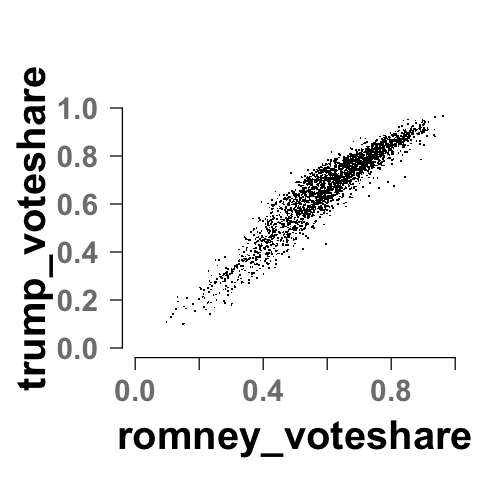

In [50]:
d = d[ , romney_voteshare := .5 - (obama_margin / 2)]
source("http://ischool.berkeley.edu/~d.alex.hughes/code/pubPlot.R")
d[ , plot(romney_voteshare, trump_voteshare, pch = ".", 
          xlim=c(0,1), ylim=c(0,1))]

## Fit Models on 2012 Returns 
One of the blocking features that we used in the design of this experiment was the 2012 two-party vote share. As a result, we have very good, orthagonal variation on the percent of the elctoral that voted for a republican vs. democratic candidate and the treatment conditions that we asisgned to each local election offical. There, is, however, no evidence to suggest that differences in the 2012 two-party vote share change the responsiveness of local election officials to our stimulus. 

In [51]:
m0  = d[ , lm(GotResponse ~ factor(ethnic_cue) * romney_voteshare)]
m0a = d[ , felm(GotResponse ~ factor(ethnic_cue) * romney_voteshare | factor(blockID))]
stargazer(m0, m0a, type = "text") 


                                                Dependent variable:            
                                     ------------------------------------------
                                                    GotResponse                
                                               OLS                  felm       
                                               (1)                   (2)       
-------------------------------------------------------------------------------
factor(ethnic_cue)1                           -0.084               -0.066      
                                             (0.070)               (0.067)     
                                                                               
factor(ethnic_cue)2                           0.078                 0.088      
                                             (0.070)               (0.067)     
                                                                               
factor(ethnic_cue)3                    

## Fit Models on 2016 Returns 
We turn to examine whether the relationship between our stimulus and the outcome is mediated by the 2016 electoral outcomes. Here, we fit models that interact the `ethic_cue` treatment variable with Republican two-party voteshare in the election (called `trump_voteshare`). We find that, in models that *do* or *do not* include block indicators that there is a clear effect: geograhies that voted at higher rates for the Republican candidate also discriminate against Arab names at higher rates. 

In [52]:
m1 = d[ , lm(GotResponse ~   factor(ethnic_cue) * trump_voteshare)]
m2 = d[ , felm(GotResponse ~ factor(ethnic_cue))]
m3 = d[ , felm(GotResponse ~ factor(ethnic_cue) * trump_voteshare | factor(blockID))]
m4 = d[ , felm(GotResponse ~ I(ethnic_cue != 0) * trump_voteshare | factor(blockID))]
stargazer(m0, m0a, m1, m3, type = 'text', omit.stat = c('ser', 'F'))


                                            Dependent variable:        
                                     ----------------------------------
                                                GotResponse            
                                       OLS     felm     OLS      felm  
                                       (1)      (2)     (3)      (4)   
-----------------------------------------------------------------------
factor(ethnic_cue)1                   -0.084  -0.066   -0.059   -0.054 
                                     (0.070)  (0.067) (0.070)  (0.068) 
                                                                       
factor(ethnic_cue)2                   0.078    0.088   0.066    0.061  
                                     (0.070)  (0.067) (0.070)  (0.067) 
                                                                       
factor(ethnic_cue)3                   -0.018  -0.011   0.050    0.050  
                                     (0.070)  (0.067) (0.070)  

In [53]:
m = capture.output( 
    stargazer(m0, m0a, m1, m3, 
              type = 'latex', 
              out = './trumpHTEtable.tex', 
              label = 'tab:trumpHTE', 
              covariate.labels = c('Latino Cue', 'Black Cue', 'Arab Cue', '2012 R. Vote Share', 
                                   'Latino Cue $\\times$ 2012 R. Votes Share',
                                   'Black Cue $\\times$ 2012 R. Vote Share', 
                                   'Arab Cue $\\times$ 2012 R. Vote Share', 
                                   '2016 R. Vote Share', 
                                   'Latino Cue $\\times$ 2016 R. Votes Share',
                                   'Black Cue $\\times$ 2016 R. Vote Share', 
                                   'Arab Cue $\\times$ 2016 R. Vote Share', 
                                   'Intercept'), 
              add.lines = list(c('Block Fixed Effects', 'No', 'Yes', 'No', 'Yes')),
              omit.stat = c('ser', 'F', 'adj.rsq'), 
              font.size = "small"
             )
    )

In [54]:
pred.data = data.frame( 
  ethnic_cue = factor(c(rep(0, 100), rep(1, 100), rep(2, 100), rep(3, 100))), 
  trump_voteshare = rep(seq(from=min(d$trump_voteshare, na.rm=T), to=max(d$trump_voteshare, na.rm=T), length.out = 100) , 4)
)
pred.data$fit    = predict.lm(m1, newdata=pred.data, interval = 'confidence')
pred.data$se.fit = predict.lm(m1, newdata=pred.data, se.fit = T,)$se.fit
pred.data$low.ci = predict.lm(m1, newdata = pred.data, interval = 'confidence', level=0.95)[ , 'lwr']
pred.data$high.ci= predict.lm(m1, newdata = pred.data, interval = 'confidence', level=0.95)[ , 'upr']
pred.data = data.table(pred.data)

In [55]:
white.col  = rgb(.7, .7, .7, 0.5, 255)
latino.col = rgb(0, 0, .7, 0.25)
black.col  = rgb(0, 0, 0.3, 0.25)
arab.col   = rgb(.7, .7, .7, 0.75)
dens = density(d$trump_voteshare, na.rm=T, from = 0, to=1)

pdf('./HTEtrump.pdf')
source("http://ischool.berkeley.edu/~d.alex.hughes/code/pubPlot.R")
pred.data[ethnic_cue == 0, 
          plot(x = trump_voteshare, y = fit, 
               type = "n", ylim = c(0.3, 0.8), col = "black", 
               ylab = "Probability Respond",   yaxt = 'n', 
               xlab = "Republican Vote Share", xaxt = 'n',
#                main = "Republican Districts Less Responsive to Arab Names"
              )]
axis(1, at = c(seq(0,.8, 0.2), .95), labels = c("0", "20", "40", "60", "80", "100%"))
axis(2, at = seq(0.2, 0.8, by=0.1), labels = c("20", "30", "40", "50", "60", "70", "80%"))
pred.data[ethnic_cue == 0, 
          polygon(x = c(trump_voteshare, rev(trump_voteshare)), 
                  y = c(low.ci, rev(high.ci)), 
                  border = NA, 
                  col = white.col)]
pred.data[ethnic_cue == 3, 
          polygon(x = c(trump_voteshare, rev(trump_voteshare)), 
                  y = c(low.ci, rev(high.ci)), 
                  border = NA, col = arab.col)]
pred.data[ethnic_cue == 0, 
          points(x = trump_voteshare, y = fit,
                 type = "l", lty = 1)]
pred.data[ethnic_cue == 3, 
          points(x = trump_voteshare, 
                 y = fit, 
                 type = "l", lty = 2)]
legend(x=.15, y=.45, legend = c("White Cue", "Arab Cue"), border = NA, 
#        fill = c(white.col, arab.col), 
       lty = c(1,2), merge = TRUE,
       bty='n', cex = 1.5)
# legend(x=.15, y=.40, legend = c("White Cue", "Arab Cue"), border = NA, 
#        lty = c(1,2), 
#        bty='n', cex = 1.5)


rug(d$trump_voteshare)
points(x = dens$x, y=.3 + dens$y/50, type = 'l') # moving into the plotting window 
dev.off()

NULL

NULL

NULL

NULL

NULL

pdf 
  2

<img src='./HTEtrump.pdf'>

## Models Fit on 2012 v. 2016 Republican Vote Share 
Is there something unique about areas that moved _uniquely_ toward Trump? That is, given a baseline level of support for the Republican candidate in 2012, did those that moved toward the Republican candidate in 2016 present a unique effect? 


                               Dependent variable:            
                    ------------------------------------------
                                   GotResponse                
                              OLS                  felm       
                              (1)                   (2)       
--------------------------------------------------------------
Latino                       -0.009               -0.018      
                            (0.027)               (0.026)     
                                                              
Black                        0.004                -0.011      
                            (0.026)               (0.026)     
                                                              
Arab                         -0.035               -0.042      
                            (0.027)               (0.027)     
                                                              
R Diff                     -0.899***             -0.69

NULL

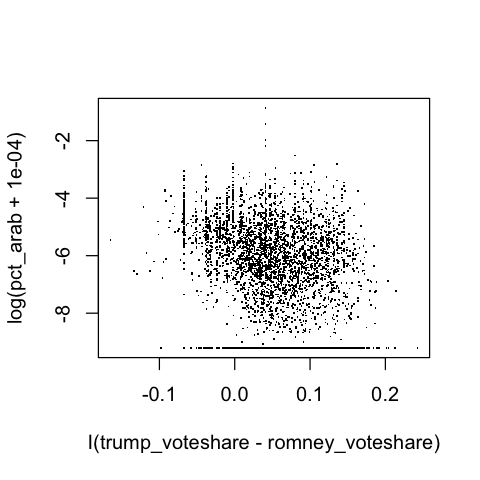

In [56]:
m0  = d[ ,   lm(GotResponse ~ factor(ethnic_cue) * I(trump_voteshare - romney_voteshare) +  romney_voteshare)]
m1  = d[ , felm(GotResponse ~ factor(ethnic_cue) * I(trump_voteshare - romney_voteshare) +  romney_voteshare | blockID)]
stargazer(m0, m1, type = "text", 
    covariate.labels = c("Latino", "Black", "Arab", "R Diff", "Romney", 
                         "Latino * R Diff", "Black * R Diff", "Arab * R Diff")
          )

d[ , plot(I(trump_voteshare - romney_voteshare), log(pct_arab+0.0001), pch = ".")]

<a id="interruption"></a> 
# 4. Interruption by Notification
[toc](#toc)

As we note in the paper, on November 2nd, an email was sent from the NASS, the professional organization for secrataaries of state. While this event presents a potential problem of interference between units, the responses collected from units *before* the interference event can reasonably be used to draw inference. 

However, at the same time, the nature of the data generating procedure -- an audit study where the failure to obtain a response from an experiemntal unit is a meaningful piece of data -- may raise some questions about how the notification of secretaries of state affected the results of this audit study. We make three claimss. 

1. In this study, the time at which widespread notification was sent out left little data to *potentially* effect causal effect estimates. 
2. Responses collected before widespread notification are meaningful data points; 
3. Causal estimates will only be biased if notification causes conditionally different response to treatment. 

First and foremost, in this study as well as the study conduced by White, Nathan, and Faller (2015) as well as several other audit studies (e.g. Gell-Redman (*in press*), Crabtree (*in press*)) the vast majority of those responses that are going to be returned to the sender by subjects are received within 27 hours of sending. We note this because there is a clear pattern that subjects fall into. (1) They respond immediately; (2) they respond at the beginning of business the next day; or (3) they do not respond. Indeed, registrars in our sample fall well within this pattern of behavior -- the median time to response, for those who respond to us as 8 hours. 

In the remainder of this section, we demonstrate how slow the response rate was in the time immediately preceeding the widespread notification. 

White, Nathan and Faller (2015) elect to remove from consideration states that the authors suspected had violated the non-interference or exclusion restriction assumptions in their audit study. We contend that such a determination is unnecessairily consaervative. While it is true that responses that are received after the widespread notification of the study are indeed unique responses, those responses that are received before this notificaiton adhere to all the assumptions necessary to elucidate causal quantities from this research design. 

To demonstrate that there is little effect of trimming our data to the point that widespread notification was sent to Registrars, in this section we employ a series of duration models. We have not chosen to report our primary causal effects through these models because the difference in means and OLS estimates we *do* report remain unbiased estimators and are considerably simpler to conceptualize. Nonetheless, in this section we demonstrate that moving the censoring point for *non-response* from election day to the time when notification was sent to registrars has no appreciable effect on causal estimates.

Second, the *ex ante* expectation for a widespread notification is that registrars will be less likely to respond to an email originating from our sending domain. But, there is little reason to suspect that registrars should behave in this way. We test for differential responsivness pre-and post mailer, and find no evidence to support a theory of differential responsiveness to treatment conditional on this split. 

We ran pilots in MN, CA, OR, WA, NV. While the timing that we report in the main text excludes these western statea and Minnesota (which was also not utilized by White, Nathan, and Faller (2015)), the results that we estimate are not unique to this composed set of states. 

<a id="rateOfResponse"></a> 
## 4.A Rate of Responses
[toc](#toc)

As a descriptive matter, the rate of email responses from registrars had slowed to little more than a trickle at the time that the NASS sent an email to its members. In the next figure, we plot the total number of emails received back to our servers on the y-axis of the plot, and the (logged) time since sending on the x-axis. The rate of response of registrars might be considered as the first derivative of this plot -- or simply understood as the rate of change at a particular time within the study window. 

As the figure shows, the vast majority of response received by our servers were received quickly after leaving. The median time to response is just over 8 hours, though this distribution is highly right skewed such that a very small number of registrars take a very long time to response (e.g. $\mu$ time is 14 hours, while the $90^{th}$ percentile time to response is only 11.2 hours.

In [57]:
if(interrupt) { 
censoring.date = "2016-11-08 00:00:00"
clerk.email.date = "2016-11-02 20:00:00" # NASS email to all orgs
send.date = "2016-10-31 09:00:00"
sd = create.survival.data(cd = censoring.date)

rm(d)
d = load.data()


## also make data on non-surivival set for estimating interaction
nineOclock = as.numeric(as.POSIXct("2016-11-02 09:00:00"))
oneOclock  = as.numeric(as.POSIXct("2016-11-02 13:00:00"))

d = d[ReplyDate != "", numReply := as.numeric(as.POSIXct(ReplyDate))]
d = d[ , afterNASS := 0]
d = d[ReplyDate != ""] %>% 
  .[as.numeric(as.POSIXct(ReplyDate)) > as.numeric(as.POSIXct(clerk.email.date)), 
      afterNASS := 1]
d[ , table(afterNASS)]
}


afterNASS
   0    1 
3646   76 

What was the median time to response, for those responses that we received? Note that this is *not* the time that local election officials use to respond to our stimulus, but rather is the time between when we *sent* the email and when the election official responded. We may have sent the email at 10:00a local time, but the registrar may not have opened the email until after lunch. These two-plus hours are included in the "time to response" metric that we report here.

In [58]:
if(interrupt) { 
x = sd[GotResponse == 1 , quantile(x = time, probs = c(.5, .75, .9), na.rm = TRUE)] / 3600 

display_html(sprintf("The median time to response was %.1f hours.", x[1]))
display_html(sprintf("The 75th percentile time to response was %.1f hours.", x[2]))
display_html(sprintf("The 90th percentile time to response was %.1f hours.", x[3]))

x = sd[GotResponse == 1 , mean(x = time, na.rm = TRUE)] / 3600 

display_html(sprintf("The mean time to response was %.1f hours.", x))
}

The median time to response was 8.2 hours.

The 75th percentile time to response was 11.2 hours.

The 90th percentile time to response was 30.6 hours.

The mean time to response was 14.1 hours.

In [59]:
if(interrupt) { 
pdf("./rateOfResponse.pdf")
source("http://ischool.berkeley.edu/~d.alex.hughes/code/pubPlot.R")
par(oma=c(0,0,0,0), mar = c(5,7,4,2)+.1, lwd=3)
sd[GotResponse == 1] %>% 
#sd[GotResponse == 1 & !(state %in% c("Oregon", "Minnesota", "California", "Oregon", "Washington"))] %>% 
  .[order(time), .(time = time, count = 1:.N)] %>% 
  .[ , plot(x=time, y=count, type = "l", log = "x", 
           main = "All Responses", 
           xaxt = 'n', xlab = "Days Since Sending",
           yaxt = 'n', ylab = "", ylim = c(0,4000))
   ]
title(ylab="Responses", line=5)

# axis(side = 1, at = c(25200, 1:7*(100800)), labels = paste0(0:7))
axis(side = 1, at = c(25200, 1:8*(86400)+25200), labels = paste0(0:8))
axis(side = 2, at = c(0, 1000, 2000, 3000, 4000), labels = c("0", "1,000", "2,000", "3,000", "4,000"))
abline(v = 25200 + (8*86400),
       lty = 2, col = "gray50")
abline(v = 25200 + (2*86400) + 3600 * 20,
       lty = 2, col = "gray50")
text(x=6.3*100800, y=400, labels="Election Day", srt=90)
text(x=2.4*100800, y=400, labels="NASS Email", srt=90)
text(x=.35 * 100800, y = 3750, labels="(a)", cex = 2, col = "grey50", font=2)

dev.off()
    }

pdf 
  2

<img src="./rateOfResponse.pdf" alt="Experiment Overview" width="400">

In [60]:
if(interrupt) { 
pdf("./rateOfResponsePerCondition.pdf")
source("http://ischool.berkeley.edu/~d.alex.hughes/code/pubPlot.R")
par(oma=c(0,0,0,0), mar = c(5,7,4,2)+.1, lwd=3)
sd[GotResponse == 1 & ethnic_cue == 0 & !(state %in% c("Oregon", "Minnesota", "California", "Oregon", "Washington", "Michigan", "New Hampshire", "Colorado"))] %>% 
  .[order(time), .(time = time, count = 1:.N)] %>% 
  .[ , plot(x=time, y=count, type = "l", lty = 1, log = "x", col = "grey", lwd = 5,
           main = "No Interference States:\n Responses by Condition", 
           xaxt = 'n', xlab = "Days Since Sending",
           yaxt = 'n', ylab = "", ylim = c(0,1000))]

sd[GotResponse == 1 & ethnic_cue == 1 & !(state %in% c("Oregon", "Minnesota", "California", "Oregon", "Washington", "Michigan", "New Hampshire", "Colorado"))] %>% 
  .[order(time), .(time = time, count = 1:.N)] %>% 
  .[ , lines(x=time, y=count, lty = 4)]
sd[GotResponse == 1 & ethnic_cue == 2 & !(state %in% c("Oregon", "Minnesota", "California", "Oregon", "Washington", "Michigan", "New Hampshire", "Colorado"))] %>% 
  .[order(time), .(time = time, count = 1:.N)] %>% 
  .[ , lines(x=time, y=count, lty = 3)]
sd[GotResponse == 1 & ethnic_cue == 3 & !(state %in% c("Oregon", "Minnesota", "California", "Oregon", "Washington", "Michigan", "New Hampshire", "Colorado"))] %>% 
  .[order(time), .(time = time, count = 1:.N)] %>% 
  .[ , lines(x=time, y=count, lty = 2)]
       
title(ylab="Responses", line=4)
axis(side = 1, at = c(25200, 1:8*(86400)+25200), labels = paste0(0:8))
axis(side = 2, at = c(0, 250, 500, 750, 1000), labels = c("0", "250", "500", "750", "1,000"))
abline(v = 25200 + (8*86400),
       lty = 2, col = "gray50")
abline(v = 25200 + (2*86400) + 3600 * 20,
       lty = 2, col = "gray50")
text(x=6.3*100800, y=100, labels="Election Day", srt=90)
text(x=2.4*100800, y=100, labels="NASS Email", srt=90)
text(x=.35 * 100800, y = 950, labels="(c)", cex = 2, col = "grey50", font=2)
legend(x = 43200, y = 350, 
       legend = c("White", "Black", "Latino", "Arab"), cex=1.5,
       lty = c(1, 3, 4, 2), lwd = c(5,3,3,3), 
       col = c("grey", "black", "black", "black"))
dev.off()
}

pdf 
  2

<img src="./rateOfResponsePerCondition.pdf" alt="Experiment Overview" width="400">

Demonstrate that using all the states (that is, including MN and the western states does not change the estimates that we report. 

In [61]:
if(interrupt) { 
pdf("./rateOfResponsePerConditionAllStates.pdf")
source("http://ischool.berkeley.edu/~d.alex.hughes/code/pubPlot.R")
par(oma=c(0,0,0,0), mar = c(5,7,4,2)+.1, lwd=3)
sd[GotResponse == 1 & ethnic_cue == 0] %>% 
  .[order(time), .(time = time, count = 1:.N)] %>% 
  .[ , plot(x=time, y=count, type = "l", log = "x", 
           main = "All States: Responses by Condition", 
           xaxt = 'n', xlab = "Days Since Sending",
           yaxt = 'n', ylab = "", ylim = c(0,1000), 
           lty = 1, col = "grey", lwd = 5)
   ]
# for(i in 1:3) { 
#     sd[GotResponse == 1 & ethnic_cue == i] %>% 
#       .[order(time), .(time = time, count = 1:.N)] %>% 
#       .[ , lines(x=time, y=count, lty = i+1)]
# }
sd[GotResponse == 1 & ethnic_cue == 1] %>% 
  .[order(time), .(time = time, count = 1:.N)] %>% 
  .[ , lines(x=time, y=count, lty = 4)]
sd[GotResponse == 1 & ethnic_cue == 2] %>% 
  .[order(time), .(time = time, count = 1:.N)] %>% 
  .[ , lines(x=time, y=count, lty = 3)]
sd[GotResponse == 1 & ethnic_cue == 3] %>% 
  .[order(time), .(time = time, count = 1:.N)] %>% 
  .[ , lines(x=time, y=count, lty = 2)]    


    
    
title(ylab="Responses", line=4)
axis(side = 1, at = c(25000, 1:7*(100800)), labels = paste0(0:7))
axis(side = 2, at = c(0, 250, 500, 750, 1000), labels = c("0", "250", "500", "750", "1,000"))
abline(v = 25200 + (2*86400) + 3600 * 20,
       lty = 2, col = "gray50")
abline(v = as.numeric(
           as.POSIXct(censoring.date) - sd[ , mean(Date, na.rm = TRUE)]),
       lty = 2, col = "gray50")
text(x=6*100800, y=100, labels="Election Day", srt=90)
text(x=2.4*100800, y=100, labels="NASS Email", srt=90)
text(x=.35 * 100800, y = 950, labels="(b)", cex = 2, col = "grey50", font=2)
legend(x = 43200, y = 350, 
       lty = c(1,3,4,2), lwd = c(5,3,3,3), 
       legend = c("White", "Black", "Latino", "Arab"), 
       col = c("grey", "black", "black", "black"), , cex=1.5)

dev.off()
    }

pdf 
  2

<img src="./rateOfResponsePerConditionAllStates.pdf" alt="Experiment Overview" width="400">

<a id="timeToRespond"></a>
## 4.B Time for Registrars to Respond 
[toc](#toc)

An interesting question that has not been answered in audit studies conducted with government officicals is the amount of time that the audit study requires of each official. This question has its roots both in understanding what is being asked of subjects, and also in understanding the costs of executing the audit study. 

One of the difficulties with this measurement -- a difficulty that has likely caused previous scholars to overlook this interesting result -- is that it is not possible using standard consumer email to know *when* a subject began the task of addressing the audit. One might consider the response task beginning at the time the audit was initiated and then simply compute the time between receiving a response to the audit task. Clearly, however, this will tend to over-estimate the amount of time required to a task, beacuse it is not the case that *all* units begin working on the task immediately. 

In our project, we utilized a standard practice in direct-consumer contact and included an image in our email. This image, which was a `1x1` pixel white image at the bottom of our email -- an image commonly called a "tracking pixel" loaded from our sending server at the time that the subject opened the email. This provides us with an approximate time that our units began the task, permitting us to calculate a difference between the beginning and completion of the task. 

In [62]:
tracker = fread(paste0(path, '../mailer/tracked_hits.csv'))

tracker = merge(tracker, d[ , .(registrar_id, RecvDate, ReplyDate, ethnic_cue, GotResponse, blockID)], 
               by.x = "registrar_id", by.y = "registrar_id")

tracker = tracker[ , timestamp.d := ymd_hms(timestamp)]
tracker = tracker[ , RecvDate.d := ymd_hms(RecvDate)]

In [63]:
tracker = tracker[ , seconds.d := RecvDate.d - timestamp.d]
tracker = tracker[ , seconds   := as.numeric(seconds.d)]
tracker = tracker[ , minutes   := seconds / 60] 

Now, we take only the first tracker hit for each LEO. This computes a conservative (long) estimate of the time to complete. We note at this point that we drop *negative* times to complete. These negative times to complete occur because of image caching, mostly on users who are utilizing consumer email clients. We note that LEOs who are using this form of technology are non-random. 

In [64]:
tracker = tracker[ , numHits := .N, by = registrar_id]

In [65]:
tracker %>% 
  .[ , .(min_seconds = min(seconds, na.rm = T), 
         max_seconds = max(seconds, na.rm = T), 
         ethnic_cue  = mean(ethnic_cue, na.rm = T)), 
    keyby = .(registrar_id)] %>% 
  .[min_seconds > 0 & max_seconds > 0] %>% 
  .[ , .("Median Mininum Seconds" = median(min_seconds), 
         "Median Mininum Minutes" = as.numeric(median(min_seconds) / 60), 
         "Median Maximum Seconds" = median(max_seconds), 
         "Median Maximum Minutes" = as.numeric(median(max_seconds) / 60))]

Median Mininum Seconds,Median Mininum Minutes,Median Maximum Seconds,Median Maximum Minutes
175,2.92,235,3.92


In [66]:
pdf(file = './timeToResponse.pdf')
source("http://ischool.berkeley.edu/~d.alex.hughes/code/pubPlot.R")
tracker %>% 
   .[ , .(min_seconds = min(seconds, na.rm = T), 
          max_seconds = max(seconds, na.rm = T), 
          ethnic_cue  = mean(ethnic_cue, na.rm = T)), 
    keyby = .(registrar_id)] %>% 
  .[min_seconds > 0 & max_seconds > 0] %>% 
  .[order(min_seconds)] %>% 
  .[ , .(t = as.numeric(min_seconds) / 60, count = 1:.N)] %>% 
  .[ , plot(t, count, type = "l", 
            xlab = "Minutes Between Open and Response", xlim = c(0, 120), 
            ylab = "Number of Hits", ylim = c(0, 2155)
           )]
dev.off()

NULL

pdf 
  2

<img src = "./timeToResponse.pdf">

<a id="noInterruptionDifference"></a>

## 4.C No Difference in Estimated Effect Due to Email 
[toc](#toc)

In duration models, the researcher specifies the point at which a "failure to convert" is recorded as such a failure. This class of models, developed in the context of health studies provide unbiased estimates in the face of right censoring. 

In the design that we registered with EGAP, we specified the censoring date as election day. On election day, any registrar who had not responded to our mailer would be classified as a non-response. This is the date that we use for the main analysis, but we also demonstrate that changing the censoring date does not change the inference drawn from this experiment. In particular, we demonstrate that changing the censoring date to the time of the NASS email to registrars' state organizations neither changes the point estimate of the causal effect, nor does it change the inference of the causal effect of senders' names. 

To perform this check, we create two survival data sets -- one with the censoring date on election day, and the other with the censoring date at the time of the NASS emailer. On both sets of data, we estiamte Cox Proportional Hazards models with only a term for the `ethnic_cue` sent to registrars. 

As is evident in the plot, and borne out in the estimated models, the estimates of the causal effect are stable both in terms of location and uncertainty in the models. 

In [67]:
if(interrupt) { 
sd1 = create.survival.data(cd = censoring.date)
sd2 = create.survival.data(cd = clerk.email.date)

mc1 = sd1[!(state %in% c("Oregon", "Minnesota", "California", "Oregon", "Washington", "Michigan", "New Hampshire", "Colorado")), 
       coxph(Surv(time, survRespond) ~ 1 + I(ethnic_cue != 0))]
mc2 = sd2[!(state %in% c("Oregon", "Minnesota", "California", "Oregon", "Washington", "Michigan", "New Hampshire", "Colorado")), 
       coxph(Surv(time, survRespond) ~ 1 + I(ethnic_cue != 0))]
mc3 = sd1[ , coxph(Surv(time, survRespond) ~ 1 + I(ethnic_cue != 0))]
mc4 = sd2[ , coxph(Surv(time, survRespond) ~ 1 + I(ethnic_cue != 0))]

stargazer(mc1, mc2, mc3, mc4, type = "text", 
          add.lines = list(c("Censoring Date", "Election", 
                             "NASS Email", "Election", "NASS Email")))
    } 


                                            Dependent variable:              
                              -----------------------------------------------
                                                   time                      
                                  (1)         (2)         (3)         (4)    
-----------------------------------------------------------------------------
I(ethnic_cue != 0)             -0.134***   -0.138***   -0.127***   -0.127*** 
                                (0.043)     (0.043)     (0.037)     (0.037)  
                                                                             
-----------------------------------------------------------------------------
Censoring Date                 Election   NASS Email   Election   NASS Email 
Observations                     4,548       4,548       6,435       6,435   
R2                               0.002       0.002       0.002       0.002   
Max. Possible R2                 1.000       1.000       1.000 

In [68]:
if(interrupt) { 
fc1 = sd1[!(state %in% c("Oregon", "Minnesota", "California", "Oregon", "Washington", "Michigan", "New Hampshire", "Colorado")), 
       coxph(Surv(time, survRespond) ~ 1 + factor(ethnic_cue))]
fc2 = sd2[!(state %in% c("Oregon", "Minnesota", "California", "Oregon", "Washington", "Michigan", "New Hampshire", "Colorado")), 
       coxph(Surv(time, survRespond) ~ 1 + factor(ethnic_cue))]
fc3 = sd1[ , coxph(Surv(time, survRespond) ~ 1 + factor(ethnic_cue))]
fc4 = sd2[ , coxph(Surv(time, survRespond) ~ 1 + factor(ethnic_cue))]

stargazer(fc1, fc2, fc3, fc4, type = "text", 
          add.lines = list(c("Censoring Date", "Election", 
                             "NASS Email", "Election", "NASS Email")))
    }


                                            Dependent variable:              
                              -----------------------------------------------
                                                   time                      
                                  (1)         (2)         (3)         (4)    
-----------------------------------------------------------------------------
factor(ethnic_cue)1             -0.097*     -0.102*     -0.076*     -0.072   
                                (0.053)     (0.053)     (0.046)     (0.046)  
                                                                             
factor(ethnic_cue)2             -0.018      -0.025      -0.009      -0.016   
                                (0.052)     (0.052)     (0.045)     (0.045)  
                                                                             
factor(ethnic_cue)3            -0.294***   -0.293***   -0.307***   -0.303*** 
                                (0.055)     (0.055)     (0.048)

In [69]:
if(interrupt) { 
m = capture.output( 
    stargazer(mc1, mc2, mc3, mc4, fc1, fc2, fc3, fc4, 
          type = "latex",
          out = "./survivalModels.tex",
          add.lines = list(c("Data Subset", "Clean", "Clean", "All", "All", "Clean", "Clean", "All", "All"),
                           c("Censoring Date", "Election", "Clerk", "Election", "Clerk", "Election", "Clerk", "Election", "Clerk")), 
          digits = 2, 
          omit.stat = c("wald", "lr", "max.rsq", "ll", "logrank"), 
          column.sep.width = "0pt", 
          covariate.labels = c("Minority Cue", "Latino Cue", "Black Cue", "Arab Cue"),
          dep.var.caption = NULL, 
          dep.var.labels.include = FALSE
         )
    )
    }

We note that even for local election officials who take more than 5 minutes, it is possible that they have opened the email to read the contents, and then set aside time to respond at a later time. 

In [70]:
display_html("To toggle on/off the raw code, click <a href='javascript:code_toggle()'>here</a>.")

To toggle on/off the raw code, click here .